<a href="https://colab.research.google.com/github/Ezzeldin-nasser939/Variational_Autoencoders/blob/main/Variational_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile('/content/drive/MyDrive/CelebA/Img/img_align_celeba.zip', 'r') as zObject:

    # Extracting all the members of the zip
    # into a specific location.
    zObject.extractall(
        path="/content")

In [ ]:
from keras import layers
from keras.layers import Input, Dense, Reshape, Concatenate, Flatten, Lambda, Reshape
from keras.models import Model
from keras import backend as K
import pandas as pd
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
from skimage.io import imread
from keras.losses import mse, binary_crossentropy
from pathlib import Path
from PIL import Image
import numpy as np

In [ ]:
df_celeb = pd.read_csv('/content/drive/MyDrive/list_attr_celeba.csv')
df_celeb.head()

,Image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
kernel_size = 3
use_mse = False
load_weights = False
VARIATIONAL = True
HEIGHT = 80
WIDTH = 80
BATCH_SIZE = 16
LATENT_DIM = 2
START_FILTERS = 32
CAPACITY = 3
CONDITIONING = True
OPTIMIZER = Adam(lr=0.01)
input_shape=(HEIGHT,WIDTH,3)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


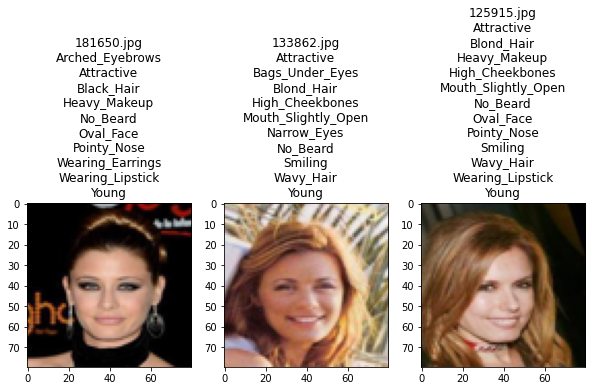

In [ ]:
def show_sample_image(nb=3, df=df_celeb, verbose=True):
    f, ax = plt.subplots(1, nb, figsize=(10,5))
    for i in range(nb):
        idx = random.randint(0, df.shape[0]-1)
        img_id = df.loc[idx].Image_id
        img_uri = '/content/img_align_celeba/' + img_id
        img = Image.open(img_uri)
        img=img.resize((HEIGHT,WIDTH),3)
        #img = skimage.io.imread()
        if verbose:
            label = img_id
            for col in df.columns:
                if df.loc[idx][col]==1:
                    label = label + '\n' + col
            if nb > 1:
                ax[i].imshow(img)
                ax[i].set_title(label)
            else:
                ax.imshow(img)
                ax.set_title(label)

    return img, list(df.loc[idx][1:df.shape[1]])

sample_img, sample_img_meta = show_sample_image()

In [ ]:
# imgs=[]
# files =Path('/content/img_align_celeba').glob('*')
# for myFile in files:
#     img=Image.open(myFile)
#     # img = img.convert('L')
#     img=img.resize((80,80),3)

#     img=np.array(img)
#     img = img/255
#     imgs.append(img)


In [ ]:
import numpy as np
def data_generation(cur_files,target_height, target_width):
    # initialize empty tensors to store the images
    X = []
    # loop through the current batch and build the tensors
    for i in range(len(cur_files)):
        # read image
        file = cur_files.iloc[i]
        img_uri = 'img_align_celeba/' + file.Image_id
        img=Image.open(img_uri)
        img=img.resize((target_height,target_width),3)
        # img=np.resize(img,((target_height, target_width),3))
        img=np.array(img)
        img = img.astype(np.float32) / 255.
        img.shape
        X.append(img)
    return X

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [ ]:
inputs = Input(shape=input_shape, name='encoder_input')
# Block-1
x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.LeakyReLU(name='lrelu_1')(x)

# Block-2
x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.LeakyReLU(name='lrelu_2')(x)

# Block-3
x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
x = layers.BatchNormalization(name='bn_3')(x)
x = layers.LeakyReLU(name='lrelu_3')(x)

# Block-4
x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
x = layers.BatchNormalization(name='bn_4')(x)
x = layers.LeakyReLU(name='lrelu_4')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(LATENT_DIM, name='z_mean')(x)
z_log_var = Dense(LATENT_DIM, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(LATENT_DIM,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 80, 80, 32)   896         ['encoder_input[0][0]']          
                                                                                                  
 bn_1 (BatchNormalization)      (None, 80, 80, 32)   128         ['conv_1[0][0]']                 
                                                                                                  
 lrelu_1 (LeakyReLU)            (None, 80, 80, 32)   0           ['bn_1[0][0]']                   
                                                                                            

In [ ]:
latent_inputs = Input(shape=(LATENT_DIM,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
# Block-1
x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
x = layers.BatchNormalization(name='bn_1')(x)
x = layers.LeakyReLU(name='lrelu_1')(x)

# Block-2
x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
x = layers.BatchNormalization(name='bn_2')(x)
x = layers.LeakyReLU(name='lrelu_2')(x)

# Block-3
x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
x = layers.BatchNormalization(name='bn_3')(x)
x = layers.LeakyReLU(name='lrelu_3')(x)


outputs = layers.Conv2DTranspose(filters=3, kernel_size=kernel_size,activation='sigmoid',padding='same',name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 25600)             76800     
                                                                 
 reshape_1 (Reshape)         (None, 20, 20, 64)        0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 20, 20, 64)       36928     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 20, 20, 64)        256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 20, 20, 64)        0         
                                                           

In [ ]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

In [ ]:
if use_mse:
    reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
    reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                              K.flatten(outputs))

reconstruction_loss *= WIDTH * HEIGHT
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [ ]:
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          503828      ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 80, 80, 3)    170627      ['encoder[0][2]']                
                                                                                                

In [ ]:
# split images into training and validation sets
msk = np.random.rand(len(df_celeb)) < 0.5
df_celeb_train = df_celeb[msk]
df_celeb_val = df_celeb[~msk]

In [ ]:
df_celeb_train.iloc[0][0]

'000001.jpg'

In [ ]:
# create image generators for training
gen = data_generation(df_celeb_train[0:10000],
                          target_height=HEIGHT,
                          target_width=WIDTH)

In [ ]:
gen=np.array(gen)

In [ ]:
gen.shape

(10000, 80, 80, 3)

In [ ]:
# create image generators for validation
# create image generators for training
gen_val = data_generation(df_celeb_val[0:1000],
                          target_height=HEIGHT,
                          target_width=WIDTH)

In [ ]:
gen_val=np.array(gen_val)

In [ ]:
gen_val.shape

(1000, 80, 80, 3)

In [ ]:
if load_weights:
    vae = vae.load_weights(args.weights)
else:
    # train the autoencoder
    vae.fit(gen,
            epochs=200,
            batch_size=BATCH_SIZE,
            validation_data=(gen_val, None))
    vae.save_weights('vae_cnn_mnist.h5')

Epoch 1/200
625/625 [==============================] - 16s 22ms/step - loss: 3906.7927 - val_loss: 3883.2200
Epoch 2/200
625/625 [==============================] - 13s 21ms/step - loss: 3826.8213 - val_loss: 3862.5232
Epoch 3/200
625/625 [==============================] - 13s 21ms/step - loss: 3806.4888 - val_loss: 3797.8640
Epoch 4/200
625/625 [==============================] - 13s 21ms/step - loss: 3800.3308 - val_loss: 3785.2271
Epoch 5/200
625/625 [==============================] - 13s 22ms/step - loss: 3792.6628 - val_loss: 3798.5686
Epoch 6/200
625/625 [==============================] - 13s 22ms/step - loss: 3788.7136 - val_loss: 3787.3298
Epoch 7/200
625/625 [==============================] - 13s 21ms/step - loss: 3785.3384 - val_loss: 3784.9004
Epoch 8/200
625/625 [==============================] - 13s 21ms/step - loss: 3782.5249 - val_loss: 3779.1030
Epoch 9/200
625/625 [==============================] - 14s 22ms/step - loss: 3780.4907 - val_loss: 3785.8137
Epoch 10/200
625/62

In [ ]:
# import torch
# from torch import nn
# from torchvision import datasets, transforms, models
# import torchvision.models as models
# import torch.nn.functional as F
# import torchvision.transforms.functional as F


1/1 [==============================] - 0s 120ms/step
latent sample:
 [[ 1.381758  -0.8302411]]


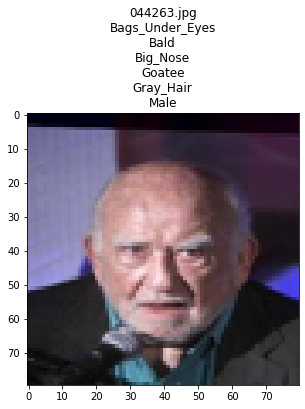

In [ ]:
from keras.metrics.base_metric import types
# select a random image
sample_img, sample_img_meta = show_sample_image(nb=1)

# function to encode a single image and return its latent space
def encode_image(img, conditioning, encoder, height, width, batch_size):
    # resize the image
    # if img.shape[0] != height or img.shape[1] != width:
    img=np.asarray(img)
    # fill the image to match the batch size
    img = np.expand_dims(img, axis=0)
    img = img.astype(np.float32)
    # use the encoder to coomputer the latent space
    z = encoder.predict(img)

    return z

# display latent space produced by the encoder
sample_img = np.asarray(sample_img)
sample_img=sample_img.astype(float) / 255.
z = encode_image(sample_img,
                 np.array(sample_img_meta),
                 encoder, HEIGHT, WIDTH, BATCH_SIZE)
print('latent sample:\n', z[0])

[[ 1.3470556 -0.7928636]]
1/1 [==============================] - 0s 149ms/step


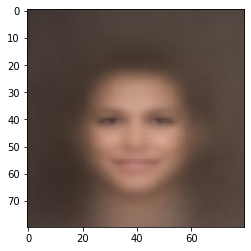

In [ ]:
def decode_embedding(z, decoder):
    z = np.expand_dims(z, axis=0)
    return decoder.predict(z)

# reconstruct original image using latent space
print(z[2])
z_reduced=z[2].reshape(2)
ret = decode_embedding(z_reduced, decoder)
plt.imshow(ret[0])
plt.show()

1/1 [==============================] - 0s 14ms/step


<Figure size 720x360 with 0 Axes>

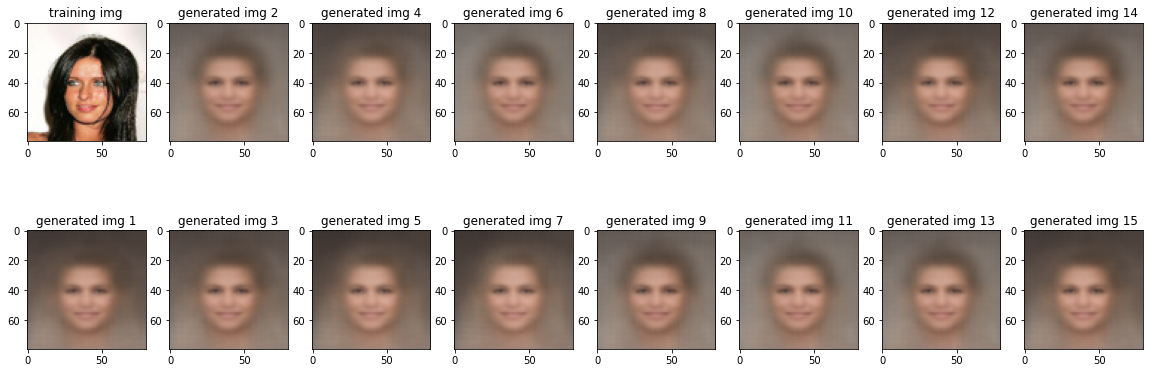

In [ ]:
def generate_new_images_vae(nb=16, smiling=None, male=None, no_beard=None, attractive=None,
                        bald=None, chubby=None, eyeglasses=None, young = None):
    sample_training_img, sample_training_img_meta = show_sample_image(nb=1, verbose=False)
    sample_training_img_meta=np.array(sample_training_img_meta)
    plt.clf();
    f, ax = plt.subplots(2, nb//2, figsize=(20,7));
    for i in range(nb):
        meta=2*np.random.rand(sample_training_img_meta.shape[0])-1
        meta[2] = attractive if attractive else meta[2]
        meta[4] = bald if bald else meta[4]
        meta[13] = chubby if chubby else meta[13]
        meta[15] = eyeglasses if eyeglasses else meta[15]
        meta[20] = male if male else meta[20]
        meta[24] = no_beard if no_beard else meta[24]
        meta[31] = smiling if smiling else meta[31]
        meta[39] = young if young else meta[39]
        z1 = np.random.rand(LATENT_DIM)
        z_reduced=z1.reshape(2)
        ret = decode_embedding(z_reduced, decoder)
        ax[i%2][i//2].imshow(ret[0])
        ax[i%2][i//2].set_title('generated img {}'.format(i))
    ax[0][0].imshow(sample_training_img)
    ax[0][0].set_title('training img')

generate_new_images_vae()